# Halo Occupation Distribution (HOD) Mocks

In this notebook, we will generate a mock halo catalog by running a FOF finder on a `LogNormalCatalog`. We will then populate those halos with galaxies via the HOD technique and compare the galaxy and halo power spectra in both real and redshift space.

**Note**

When viewing results in this notebook, keep in mind that the FOF catalog generated from the ``LogNormalCatalog`` object is only semi-realistic. We choose to use the ``LogNormalCatalog`` rather than a more realistic data set due to the ease with which we can load the mock data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging() # turn on logging to screen

## Generating Halos via the FOF Algorithm

We'll start by generating a mock galaxy catalog at $z=0.55$ from a log-normal density field.

In [4]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.EHPower(cosmo, redshift)
b1 = 2.0

input_cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

[ 000012.45 ]   0: 08-08 18:09  CatalogSource   INFO     total number of particles in LogNormalCatalog(seed=42, bias=2) = 7883861


And then, we run a friends-of-friends (FOF) algorithm on the mock galaxies to identify halos, using a linking length
of 0.2 times the mean separation between objects. Here, we only keep halos with at least 5 particle members. 

In [5]:
fof = FOF(input_cat, linking_length=0.2, nmin=5)

Now, we set the particle mass as $10^{12} \ M_\odot/h$ and create a `HaloCatalog` using the *Planck* 2015 parameters at a redshift of $z = 0.55$. Here, 'vir' specifies that we wish to create the `Mass` column as the virial mass. This mass definition is necessary for computing the analytic concentration, needed when generating the HOD galaxies. 

In [6]:
halos = fof.to_halos(cosmo=cosmo, redshift=redshift, particle_mass=1e12, mdef='vir')

[ 000038.43 ]   0: 08-08 18:10  CatalogSource   INFO     total number of particles in ArrayCatalog(size=24602) = 24602


[ 000038.43 ]   0: 08-08 18:10  CatalogSource   INFO     total number of particles in HaloCatalog(size=24602) = 24602


Finally, we convert the `HaloCatalog` object to a format recognized by the `halotools` package and initialze our HOD catalog, using the default HOD parameters.

In [7]:
halotools_halos = halos.to_halotools()
hod = HODCatalog(halotools_halos)

[ 000039.73 ]   0: 08-08 18:10  HOD             INFO     satellite fraction: 0.04


[ 000039.73 ]   0: 08-08 18:10  HOD             INFO     mean log10 halo mass: 13.10


[ 000039.73 ]   0: 08-08 18:10  HOD             INFO     std log10 halo mass: 0.30


[ 000039.73 ]   0: 08-08 18:10  HOD             INFO     total number of particles in HODCatalog(logMmin=13.03, sigma_logM=0.38, alpha=0.76, logM0=13.27, logM1=14.08) = 9505


Using the `gal_type` column, we can create subsets of the HOD catalog that contain only centrals and only satellites.

In [8]:
cen_idx = hod['gal_type'] == 0
sat_idx = hod['gal_type'] == 1

cens = hod[cen_idx]
sats = hod[sat_idx]

[ 000039.76 ]   0: 08-08 18:10  CatalogSource   INFO     total number of particles in CatalogCopy(size=9129) = 9129


[ 000039.78 ]   0: 08-08 18:10  CatalogSource   INFO     total number of particles in CatalogCopy(size=376) = 376


## Real-space Power Spectra

In this section, we compute the real-space power spectrum of the FOF halos and the HOD galaxies and compare.

In [9]:
# compute P(k) for the FOF halos
halo_power = FFTPower(halos, mode='1d', Nmesh=512)

[ 000039.80 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (HaloCatalog(size=24602) as CatalogMesh) = 24602


[ 000040.44 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 24602 out of 24602 objects to mesh


[ 000040.44 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 0.000183299


[ 000040.44 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 24602 


[ 000040.44 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000044.98 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (HaloCatalog(size=24602) as CatalogMesh) painting done


And we can compute P(k) for all galaxies, centrals only, satellites only, and the cross power between centrals and satellites.

In [10]:
gal_power = FFTPower(hod, mode='1d', Nmesh=256)
cen_power = FFTPower(cens, mode='1d', Nmesh=256)
sat_power = FFTPower(sats, mode='1d', Nmesh=256)
cen_sat_power = FFTPower(cens, second=sats, mode='1d', Nmesh=256)

[ 000052.21 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (HODCatalog(logMmin=13.03, sigma_logM=0.38, alpha=0.76, logM0=13.27, logM1=14.08) as CatalogMesh) = 9505


[ 000052.31 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 9505 out of 9505 objects to mesh


[ 000052.31 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 0.000566542


[ 000052.31 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 9505 


[ 000052.31 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000052.87 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (HODCatalog(logMmin=13.03, sigma_logM=0.38, alpha=0.76, logM0=13.27, logM1=14.08) as CatalogMesh) painting done


[ 000053.74 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (CatalogCopy(size=9129) as CatalogMesh) = 9129


[ 000053.82 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 9129 out of 9129 objects to mesh


[ 000053.83 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 0.000544131


[ 000053.83 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 9129 


[ 000053.83 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000054.33 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (CatalogCopy(size=9129) as CatalogMesh) painting done


[ 000055.19 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (CatalogCopy(size=376) as CatalogMesh) = 376


[ 000055.28 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 376 out of 376 objects to mesh


[ 000055.28 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 2.24113e-05


[ 000055.28 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 376 


[ 000055.28 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000055.77 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (CatalogCopy(size=376) as CatalogMesh) painting done


[ 000056.59 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (CatalogCopy(size=9129) as CatalogMesh) = 9129


[ 000056.59 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (CatalogCopy(size=376) as CatalogMesh) = 376


[ 000056.67 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 9129 out of 9129 objects to mesh


[ 000056.67 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 0.000544131


[ 000056.67 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 9129 


[ 000056.67 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000057.17 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (CatalogCopy(size=9129) as CatalogMesh) painting done


[ 000057.25 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 376 out of 376 objects to mesh


[ 000057.25 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 2.24113e-05


[ 000057.25 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 376 


[ 000057.25 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000057.74 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (CatalogCopy(size=376) as CatalogMesh) painting done


(10000.0, 5000000.0)

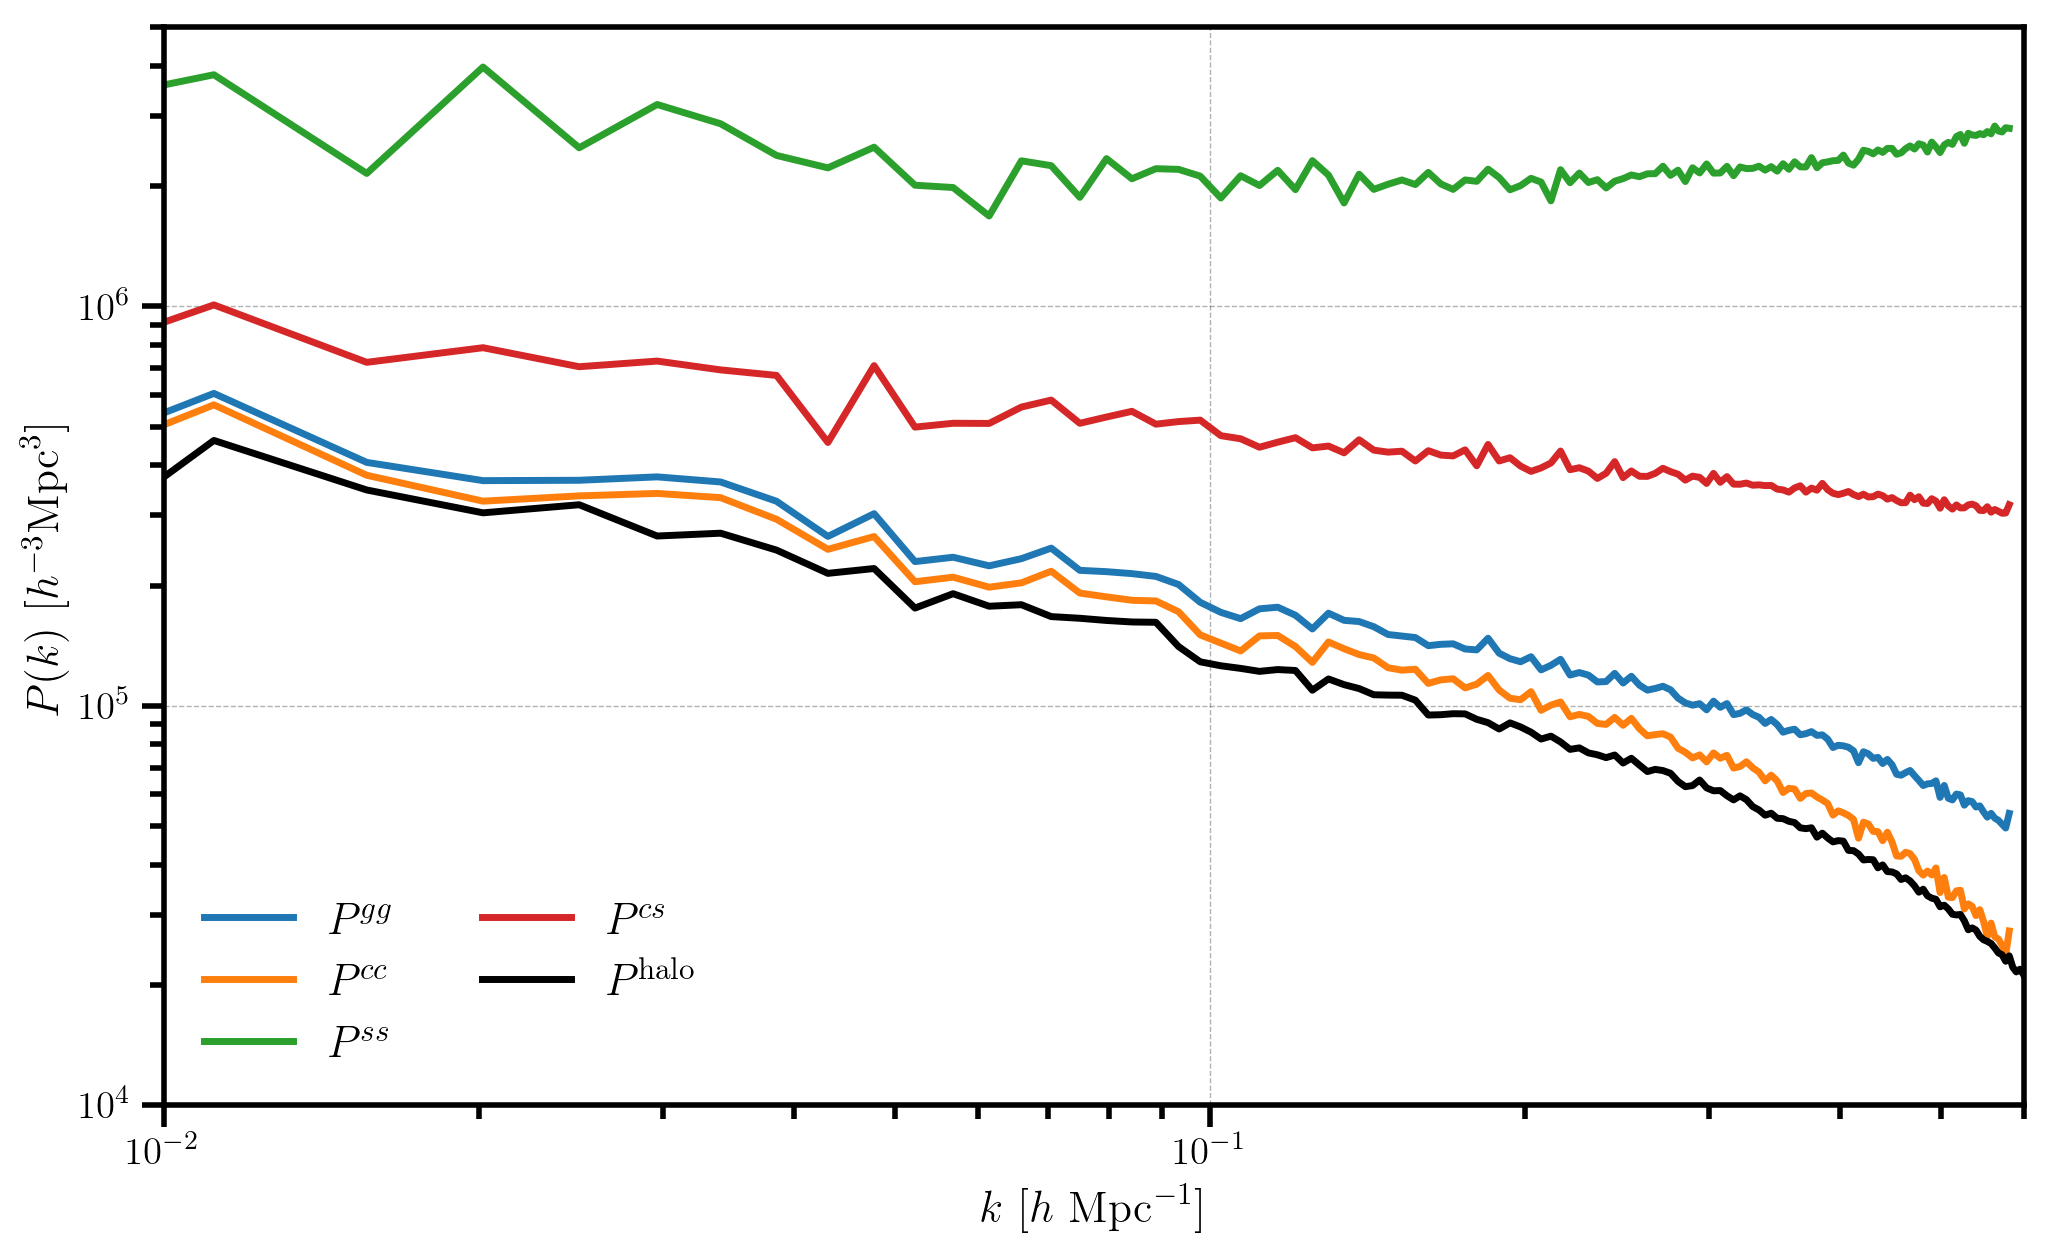

In [11]:
# plot galaxy auto power, centrals auto power, and sats auto power
labels = [r"$P^{gg}$", r"$P^{cc}$", r"$P^{ss}$"]
for i, r in enumerate([gal_power, cen_power, sat_power]):
    Pk = r.power
    plt.loglog(Pk['k'], Pk['power'].real-Pk.attrs['shotnoise'], label=labels[i])
    
# central-satellite power
Pk = cen_sat_power.power
plt.loglog(Pk['k'], Pk['power'].real, label=r"$P^{cs}$")

# the halo power
Phalo = halo_power.power
plt.loglog(Phalo['k'], Phalo['power'].real-Phalo.attrs['shotnoise'], c='k', label=r"$P^\mathrm{halo}$")
    
# add a legend and axis labels
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.ylim(1e4, 5e6)

Here, we see the high bias of the satellite power spectrum (green). Because the satellite fraction is relatively low ($f_\mathrm{sat} \simeq 0.04$), the amplitude of the total galaxy power $P^{gg}$ is only slightly larger than the centrals auto power $P^{cc}$ -- the centrals dominate the clustering signal.

## Redshift-space Power Spectra

First, we convert HOD galaxy positions from real to redshift space.

In [12]:
LOS = [0, 0, 1]
hod['RSDPosition'] = hod['Position'] + hod['VelocityOffset'] * LOS

And then compute $P(k,\mu)$ for the full HOD galaxy catalog in five $\mu$ bins.

In [13]:
mesh = hod.to_mesh(position='RSDPosition', Nmesh=256, compensated=True)
rsd_gal_power = FFTPower(mesh, mode='2d', Nmu=5)

[ 000060.41 ]   0: 08-08 18:10  CatalogMesh     INFO     total number of particles in (HODCatalog(logMmin=13.03, sigma_logM=0.38, alpha=0.76, logM0=13.27, logM1=14.08) as CatalogMesh) = 9505


[ 000060.46 ]   0: 08-08 18:10  CatalogMesh     INFO     painted 9505 out of 9505 objects to mesh


[ 000060.46 ]   0: 08-08 18:10  CatalogMesh     INFO     mean particles per cell is 0.000566542


[ 000060.46 ]   0: 08-08 18:10  CatalogMesh     INFO     sum is 9505 


[ 000060.46 ]   0: 08-08 18:10  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000060.78 ]   0: 08-08 18:10  CatalogMesh     INFO     field: (HODCatalog(logMmin=13.03, sigma_logM=0.38, alpha=0.76, logM0=13.27, logM1=14.08) as CatalogMesh) painting done


Finally, plot the galaxy $P(k,\mu)$ and compare to the measured halo power in real space. 

(10000.0, 2000000.0)

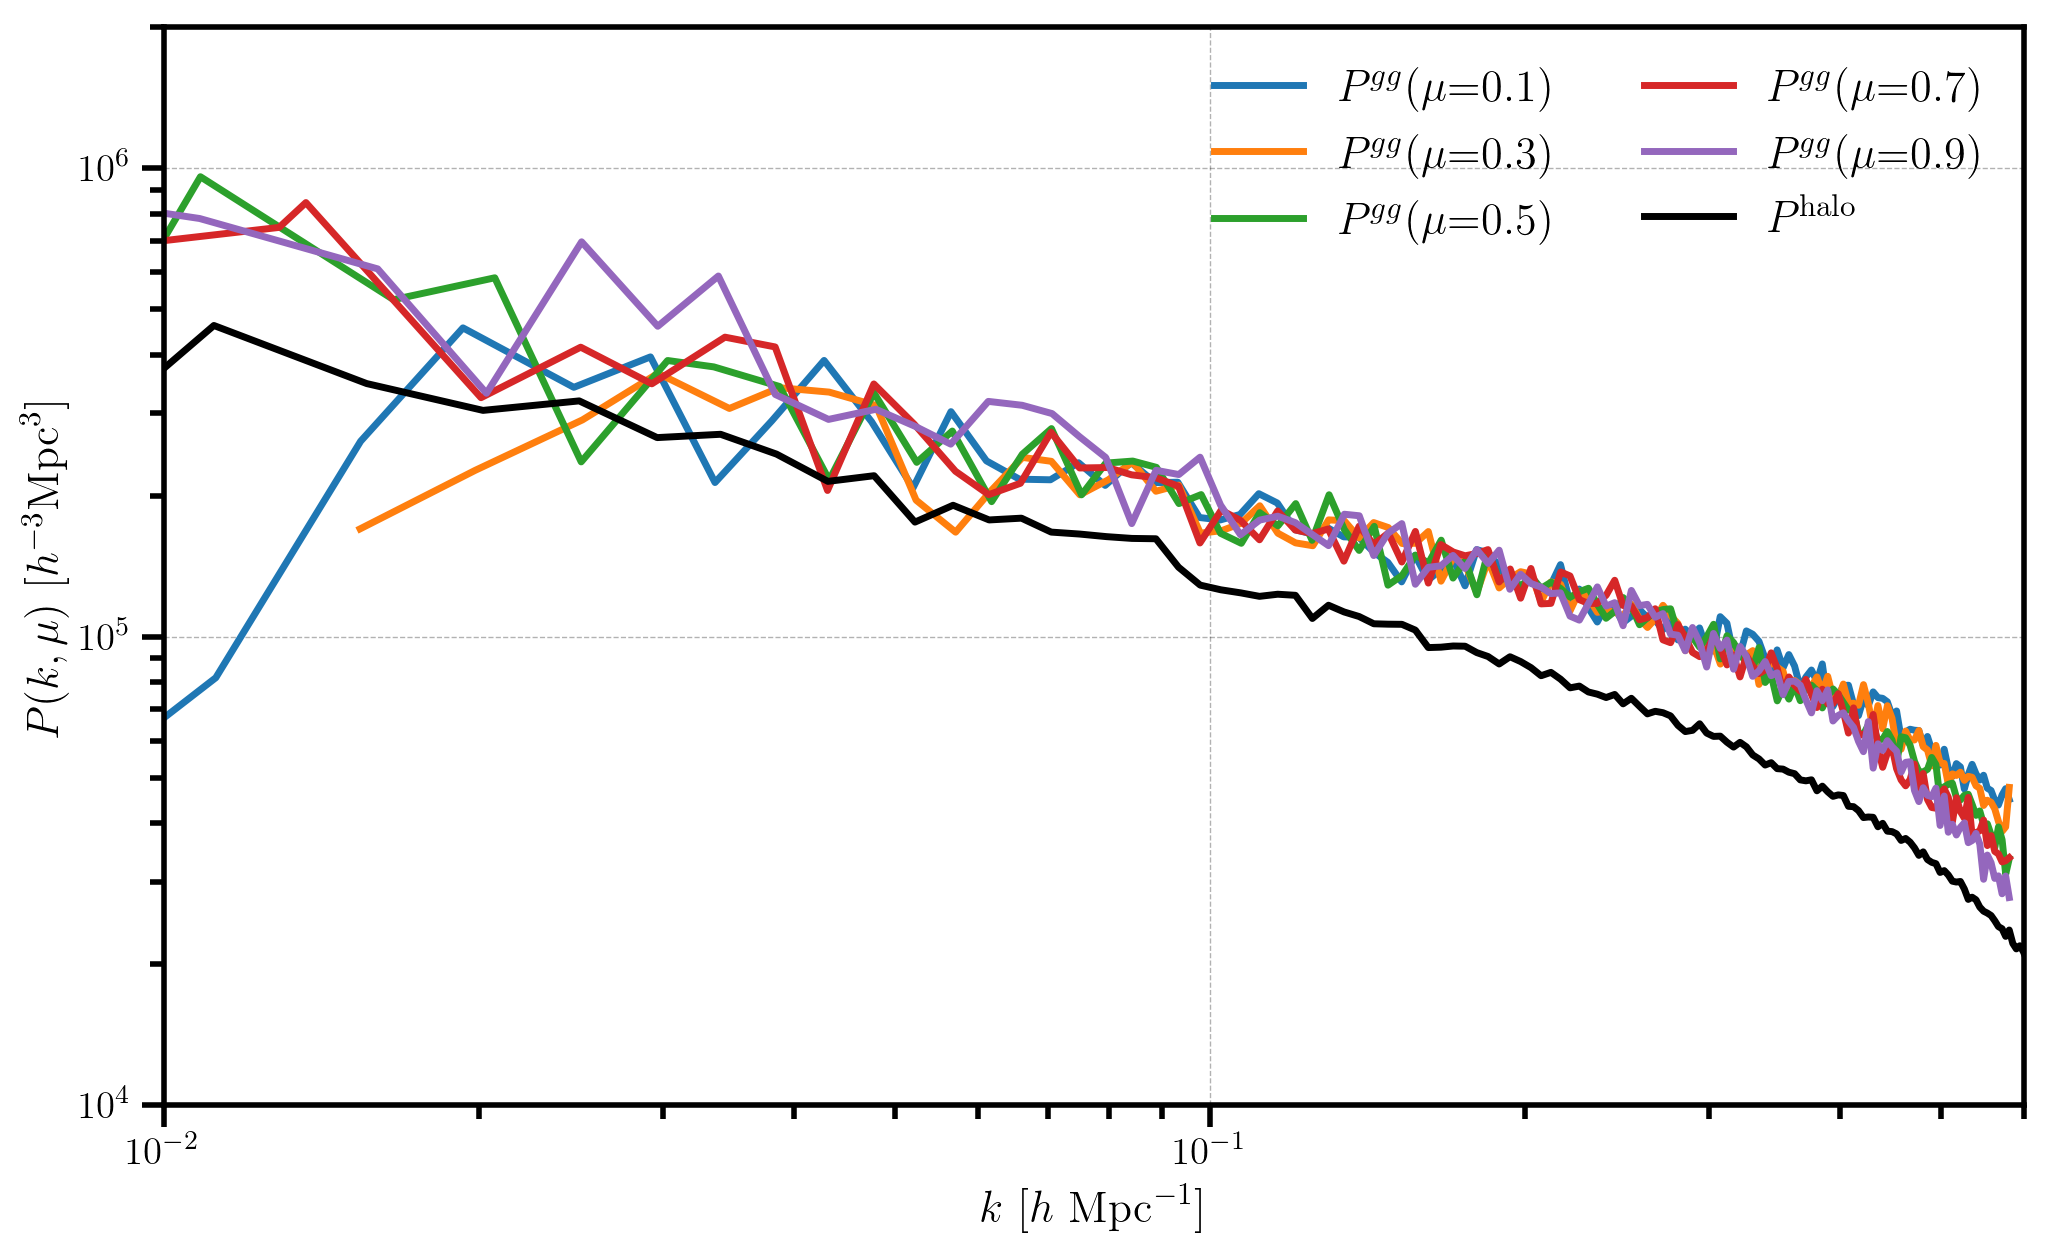

In [14]:
pkmu = rsd_gal_power.power

# plot each mu bin
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i]
    label = r'$P^{gg}(\mu$=%.1f)' %pkmu.coords['mu'][i]
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# the halo power
Phalo = halo_power.power
plt.loglog(Phalo['k'], Phalo['power'].real-Phalo.attrs['shotnoise'], c='k', label=r"$P^\mathrm{halo}$")
    
# add a legend and axis labels
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.ylim(1e4, 2e6)

In this figure, we see the effects of RSD on the HOD catalog, with the power spectrum damped at higher $\mu$ on small scales (larger $k$). 